In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function,division
from Pic.maxent_font import tick_font
from Utils.gridCV import gridCV

In [2]:
image_path = "/Users/chaoxu/code/local-spark/Data/image_qiancheng"
ratio = 0.01
model = 'tree'
version = 6

In [3]:
df = pd.read_csv("/Users/chaoxu/code/local-spark/Data/qiancheng_data/qiancheng_sample_new_merge_{0}/data.csv".format(ratio))

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,20,67,71) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_ios_test = pd.read_csv("/Users/chaoxu/code/local-spark/Data/qiancheng_vld/qiancheng_ios_vld_merge_{0}/data.csv".format(ratio))

In [5]:
# df_ios_test.dtypes

In [6]:
df_android_test = pd.read_csv("/Users/chaoxu/code/local-spark/Data/qiancheng_vld/qiancheng_android_vld_merge_{0}/data.csv".format(ratio))

In [7]:
def merge_ua_proxy(row):
    if row['uaMismatch.value'] >= 1 or row['proxyIP.value'] >=1:
        return 1
    else:
        return 0
df['proxy_ua'] = df.apply(merge_ua_proxy,axis=1)
df_ios_test['proxy_ua'] = df_ios_test.apply(merge_ua_proxy,axis=1)
df_android_test['proxy_ua'] = df_android_test.apply(merge_ua_proxy,axis=1)

In [8]:
df.os.value_counts()

android    151329
ios         86468
windows         1
Name: os, dtype: int64

In [9]:
def resample(data, positiveRatio=0.04):
    positive = data[data["label"] == 1]
    negative = data[data["label"] == 0]
    n = int((1 - positiveRatio) / positiveRatio) * positive.shape[0]
    print(n)
    _negative = negative.sample(n=n)
    df = pd.concat([positive, _negative])
    return df

In [10]:
df[['label']]=df[['label']].fillna(0)

In [11]:
df_android_test[['label']]=df_android_test[['label']].fillna(0)

In [12]:
df_ios_test[['label']]=df_ios_test[['label']].fillna(0)

In [13]:
df.timestamp.dtypes

dtype('int64')

In [14]:
from datetime import datetime, timedelta
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]) + timedelta(hours=8)
df = df.sort_values(by="timestamp")
df_maxent_id = df['maxent_id'].reset_index(drop=True)
# df = df.drop(['idcIP.anomaly', 'cracked.anomaly', 'uaMismatch.anomaly','uaMismatch.value','proxyIP.value','proxyIP.anomaly',"timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df = df.drop(["timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)

df[['label']]=df[['label']].fillna(0)
df[['label']] = df[['label']].astype(int)
df = df.loc[df['event_type'] =='ACT']
df = df.drop(['event_type'],axis=1)

In [15]:
# df_maxent_id

In [16]:
df_android_test["timestamp"] = pd.to_datetime(df_android_test['timestamp'], unit='ms', utc=True)
df_android_test["timestamp"] = pd.DatetimeIndex(df_android_test["timestamp"]) + timedelta(hours=8)
df_android_test = df_android_test.sort_values(by="timestamp")
df_android_maxent_id = df_android_test['maxent_id'].reset_index(drop=True)
# df_android_test = df_android_test.drop(['idcIP.anomaly', 'cracked.anomaly','uaMismatch.value','proxyIP.value', 'proxyIP.anomaly','uaMismatch.anomaly',"timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df_android_test = df_android_test.drop(["timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df_android_test[['label']]=df_android_test[['label']].fillna(0)
df_android_test[['label']] = df_android_test[['label']].astype(int)
df_android_test = df_android_test.loc[df_android_test['event_type'] =='ACT']
df_android_test = df_android_test.drop(['event_type'],axis=1)

In [17]:
df_ios_test["timestamp"] = pd.to_datetime(df_ios_test['timestamp'], unit='ms', utc=True)
df_ios_test["timestamp"] = pd.DatetimeIndex(df_ios_test["timestamp"]) + timedelta(hours=8)
df_ios_test = df_ios_test.sort_values(by="timestamp")
df_ios_maxent_id = df_ios_test['maxent_id'].reset_index(drop=True)
# df_ios_test = df_ios_test.drop(['idcIP.anomaly', 'cracked.anomaly','uaMismatch.value','proxyIP.value','proxyIP.anomaly', 'uaMismatch.anomaly',"timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df_ios_test = df_ios_test.drop(["timestamp","maxent_id","timestamp",'ipSeg24','ipGeo','event_id','scenario'],axis=1)
df_ios_test[['label']]=df_ios_test[['label']].fillna(0)
df_ios_test[['label']] = df_ios_test[['label']].astype(int)
df_ios_test = df_ios_test.loc[df_ios_test['event_type'] =='ACT']
df_ios_test = df_ios_test.drop(['event_type'],axis=1)

In [18]:
import re
anormaly = re.compile('.*anomaly$')
anormaly_match = np.vectorize(lambda x:bool(anormaly.match(x)))
anormaly_cols = df.columns.values[anormaly_match(df.columns.values)]

value = re.compile('.*value$')
value_match = np.vectorize(lambda x:bool(value.match(x)))
value_cols = df.columns.values[value_match(df.columns.values)]

count = re.compile('.*counts$')
count_match = np.vectorize(lambda x:bool(count.match(x)))
count_cols = df.columns.values[count_match(df.columns.values)]

loan = re.compile('.*loan$')
loan_match = np.vectorize(lambda x:bool(loan.match(x)))
loan_cols = df.columns.values[loan_match(df.columns.values)]

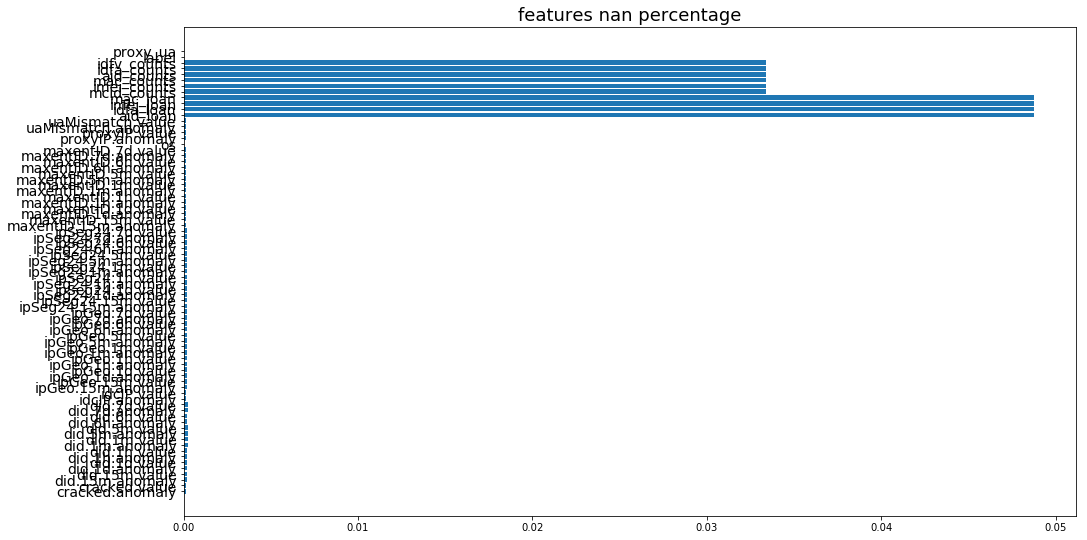

In [19]:
cols = df.columns
fig, ax = plt.subplots(figsize=(16,9))
ax.barh(range(len(cols)),df[cols].isnull().sum()/df.shape[0])
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols, size=14)
ax.set_title('features nan percentage',size= 18)
plt.show()

In [20]:
df[loan_cols]=df[loan_cols].fillna(0)
df_android_test[loan_cols]=df_android_test[loan_cols].fillna(0)
df_ios_test[loan_cols]=df_ios_test[loan_cols].fillna(0)

In [21]:
df[anormaly_cols] = df[anormaly_cols].fillna(1)
df[value_cols] = df[value_cols].fillna(1)
df_android_test[anormaly_cols] = df_android_test[anormaly_cols].fillna(1)
df_android_test[value_cols] = df_android_test[value_cols].fillna(1)
df_ios_test[anormaly_cols] = df_ios_test[anormaly_cols].fillna(1)
df_ios_test[value_cols] = df_ios_test[value_cols].fillna(1)

In [22]:
obj_df = df.select_dtypes(include=['object'])
obj_df.columns

Index([u'cracked.value', u'idcIP.value', u'os', u'proxyIP.value',
       u'uaMismatch.value'],
      dtype='object')

In [23]:
bool_df = df.select_dtypes(include=['bool'])
bool_df.columns

Index([], dtype='object')

In [24]:
df[count_cols]=df[count_cols].fillna(0)
df_android_test[count_cols]=df_android_test[count_cols].fillna(0)
df_ios_test[count_cols]=df_ios_test[count_cols].fillna(0)

In [25]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df[show_missing()].isnull().sum()

Series([], dtype: float64)

整体的label平衡性

In [26]:
df.label.value_counts(normalize=True)

0    0.982237
1    0.017763
Name: label, dtype: float64

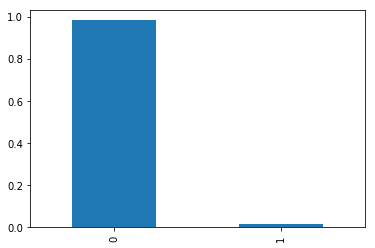

In [27]:
df.label.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [28]:
df_ios = df.loc[df.os == 'ios']

In [29]:
obj_cols = obj_df.columns.values.tolist()
print(obj_cols)
bool_cols = bool_df.columns.values.tolist()
print(bool_cols)
encoder_cols = obj_cols + bool_cols
print(encoder_cols)

['cracked.value', 'idcIP.value', 'os', 'proxyIP.value', 'uaMismatch.value']
[]
['cracked.value', 'idcIP.value', 'os', 'proxyIP.value', 'uaMismatch.value']


In [30]:
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [31]:
df_ios = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_ios)
df_ios_test = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_ios_test)

In [32]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df_ios[show_missing()].isnull().sum()

Series([], dtype: float64)

In [33]:
# cols = df_ios.columns
# fig, ax = plt.subplots(figsize=(16,9))
# ax.barh(range(len(cols)),df_ios[cols].isnull().sum()/df_ios.shape[0])
# ax.set_yticks(range(len(cols)))
# ax.set_yticklabels(cols, size=14)
# ax.set_title('features nan percentage',size= 18)
# plt.show()

In [34]:
ios_drop = ['os','aid_loan','imei_loan','mac_loan','imei_counts','mac_counts','aid_counts']
df_ios=df_ios.drop(ios_drop,axis=1)
df_ios_test=df_ios_test.drop(ios_drop,axis=1)

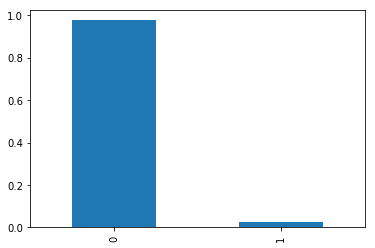

In [35]:
df_ios.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/ios_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [36]:
# from sklearn.cross_validation import train_test_split
# def splitData(df, ratio):
#     """
#     """
#     positiveData = df[df["label"] == 1].copy(deep=True)
#     _positiveTrain, _positiveTest = train_test_split(positiveData, train_size=ratio)
#     negativeData = df[df["label"] == 0].copy(deep=True)
#     _negativeTrain, _negativeTest = train_test_split(negativeData, train_size=ratio)
#     train_set = pd.concat([_positiveTrain, _negativeTrain])
#     test_set = pd.concat([_positiveTest, _negativeTest])
#     return train_set, test_set

df_ios_train = df_ios
X_ios_train = df_ios_train.ix[:, df_ios_train.columns != 'label']
X_ios_test  = df_ios_test.ix[:, df_ios_test.columns != 'label']
y_ios_train = df_ios_train.ix[:, df_ios_train.columns == 'label']
y_ios_test  = df_ios_test.ix[:, df_ios_test.columns == 'label']
print("Number transactions ios train dataset: ", X_ios_train.shape[0])
print("Number transactions ios train dataset: ", y_ios_train.shape[0])
print("Number transactions ios test dataset: ", X_ios_test.shape[0])
print("Total number of ios transactions: ", X_ios_train.size)

Number transactions ios train dataset:  86468
Number transactions ios train dataset:  86468
Number transactions ios test dataset:  451326
Total number of ios transactions:  5966292


In [37]:
from __future__ import print_function,division
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('label 1')
    plt.xlabel('label 0')

In [38]:
def get_ios_group_label(row):
#     print(row['y_ios_test'].values)
    if row['y_ios_test'].values[0] == 1:
        return row['y_ios_pred'].max()
    else:
        return row['y_ios_pred'].min()

In [39]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,precision_score,classification_report
# from sklearn.ensemble import RandomForestClassifier
# params = {'max_features':'auto', 'max_depth': 3, 'min_samples_split': 5, \
#             'class_weight':'balanced','oob_score':True}
# params['n_estimators'] = 2
# params['n_jobs'] = 50
# forest = RandomForestClassifier(**params)
# clf_a = forest.fit(X_ios_train,y_ios_train.values.ravel())
# y_ios_pred = clf_a.predict(X_ios_test)

# df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
# df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
# df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
# df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

In [40]:
tree_base_params = {
    'criterion' : 'gini',
    'random_state' : 27,
    'class_weight':"balanced"
}
cv_params = {
    'pre_dispatch': '2*n_jobs', 
    'refit':True,
    'scoring':'roc_auc',
#     'scoring':'f1_macro',
#     'scoring':'f1_weighted',
#     'scoring':'average_precision',
#     'scoring':'accuracy',
#     'scoring':'recall',
    'cv':5,
    'verbose':0
}
all_test_params = {
    'max_depth':range(4,20,2),    
    'max_leaf_nodes':range(2,20,2),
    'min_samples_leaf':range(30,100,10),
    'min_samples_split':range(30,100,10),
    'min_impurity_decrease':[i/100.0 for i in range(0,5)]
}
# all_test_params = {
# #     'max_depth':range(1,5,1),
#     'max_depth':range(4,20,2), 
#     'min_samples_leaf':range(80,160,10),
#     'min_samples_split':range(10,110,10),
#     'max_leaf_nodes':range(10,100,10),
#     'max_features':['sqrt','log2',None],
#     'min_impurity_decrease':[i/100.0 for i in range(0,5)]
# }

find best params of {'min_samples_split': [30, 40, 50, 60, 70, 80, 90]}
find best params of {'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_impurity_decrease': [0.0, 0.01, 0.02, 0.03, 0.04]}
find best params of {'max_depth': [4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90]}


/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


get grid score is [mean: 0.71314, std: 0.07113, params: {'min_samples_leaf': 30}, mean: 0.71314, std: 0.07113, params: {'min_samples_leaf': 40}, mean: 0.71314, std: 0.07113, params: {'min_samples_leaf': 50}, mean: 0.71196, std: 0.07312, params: {'min_samples_leaf': 60}, mean: 0.71164, std: 0.07307, params: {'min_samples_leaf': 70}, mean: 0.71164, std: 0.07307, params: {'min_samples_leaf': 80}, mean: 0.70782, std: 0.06980, params: {'min_samples_leaf': 90}]
get best parameters is {'random_state': 27, 'criterion': 'gini', 'min_samples_split': 90, 'max_leaf_nodes': 14, 'min_samples_leaf': 30, 'max_depth': 6, 'min_impurity_decrease': 0.0, 'class_weight': 'balanced'}
get best score is 0.713142543029


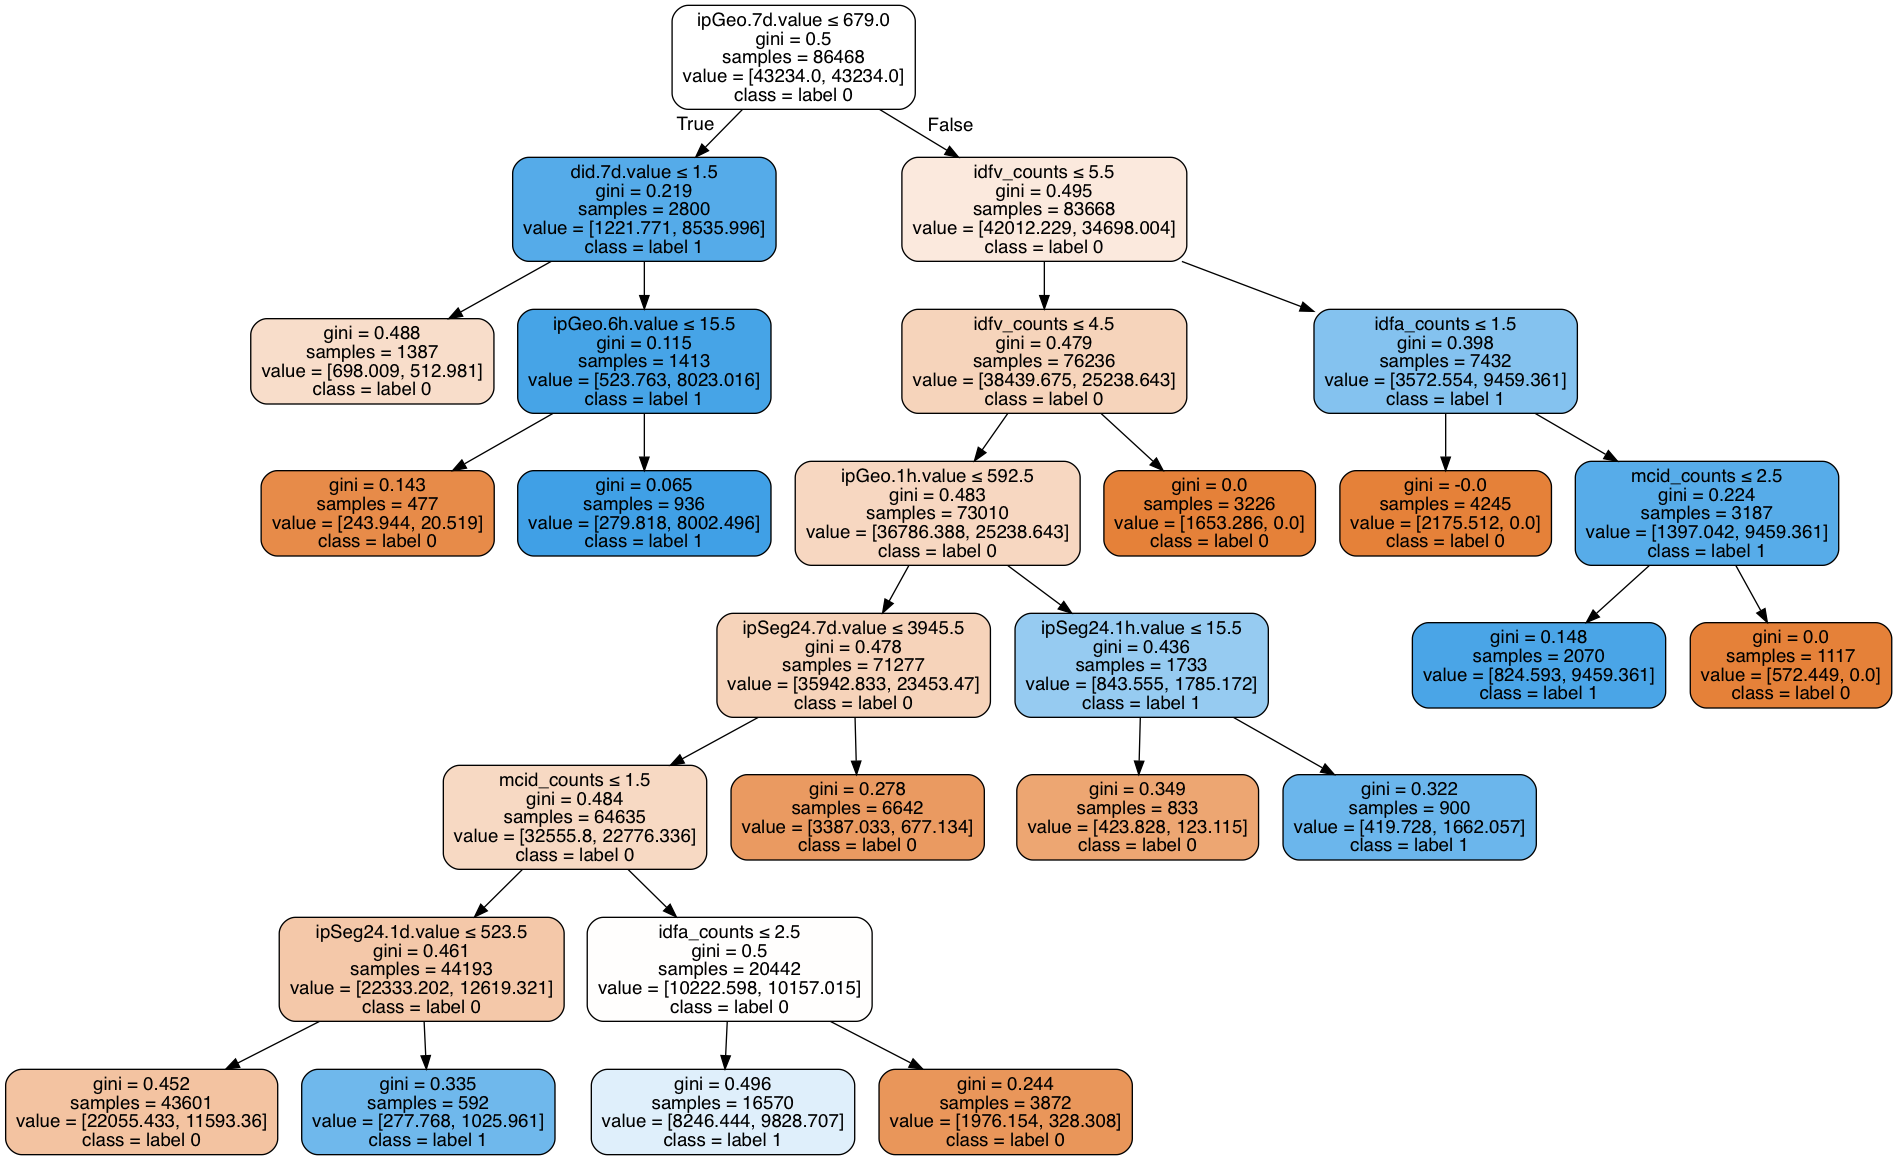

In [41]:
from sklearn import tree
from IPython.display import Image
import pydotplus
X_ios_cols = X_ios_train.columns
X_ios_train_cv = X_ios_train[X_ios_cols]
y_ios_train_cv = y_ios_train['label']
ios_params,_clf = gridCV(clf=tree.DecisionTreeClassifier,X=X_ios_train_cv,y=y_ios_train_cv,
                         base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_ios = tree.DecisionTreeClassifier(**ios_params)
clf_0 = clf_ios.fit(X_ios_train, y_ios_train)

ios_dot_data = tree.export_graphviz(clf_0, out_file=None, feature_names=X_ios_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(ios_dot_data)
# graph.write_pdf("dec_tree.pdf")

Image(graph.create_png())

In [42]:
save_path = image_path + "/ios_tree-{0}-{1}-{2}.png".format(version,ratio,model)
graph.write_png(save_path)

True

31141494
45289
Recall metric in the testing dataset:  0.428
Precision metric in the testting dataset: 0.0249301025163
f2 metric in the testting dataset: 9.89158878505
             precision    recall  f1-score   support

          0       0.99      0.81      0.89     44789
          1       0.02      0.43      0.05       500

avg / total       0.98      0.81      0.88     45289



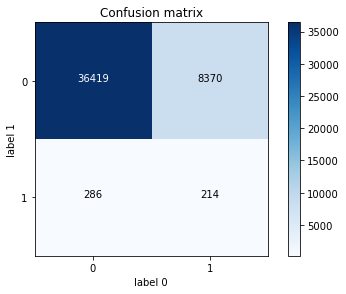

In [43]:
y_ios_pred = clf_0.predict(X_ios_test)

df_y_ios_pred = pd.DataFrame(y_ios_pred,columns=['y_ios_pred'])
df_y_ios_test = pd.DataFrame(y_ios_test.values,columns=['y_ios_test'])
df_pred = pd.concat([df_ios_maxent_id,df_y_ios_pred,df_y_ios_test],axis=1)
df_pred_g = df_pred.groupby(['maxent_id','y_ios_test'])

df_pred_g_apply=df_pred_g.apply(lambda x:get_ios_group_label(x)).reset_index(name='y_ios_pred_max')

y_ios_test_m = df_pred_g_apply['y_ios_test']
y_ios_pred_m = df_pred_g_apply['y_ios_pred_max']

print(X_ios_test.size)
print(y_ios_test_m.size)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_ios_test_m,y_ios_pred_m)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_ios_test_m, y_ios_pred_m, target_names=['0','1']))
save_path = image_path + "/tree_ios_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

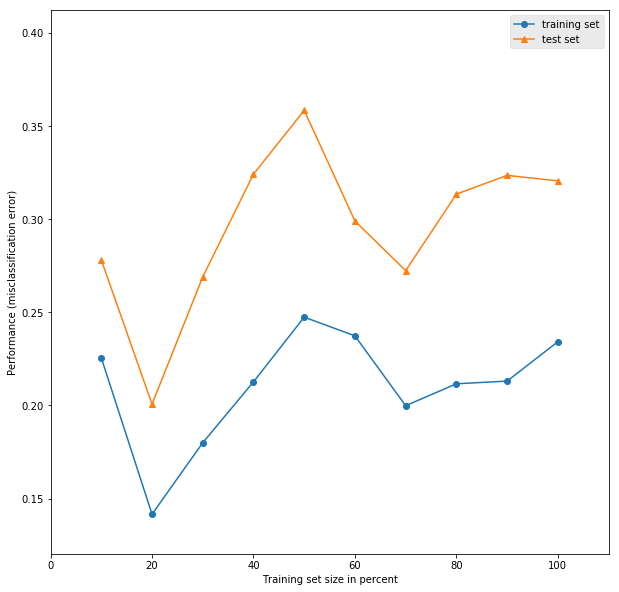

In [44]:
from mlxtend.plotting import plot_learning_curves
y_ios_train_f = y_ios_train.label.astype(float)
y_ios_test_f = y_ios_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_ios_train, y_ios_train_f, X_ios_test, y_ios_test_f, clf_0, print_model=False,style='ggplot')

save_path = image_path + "/ios_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


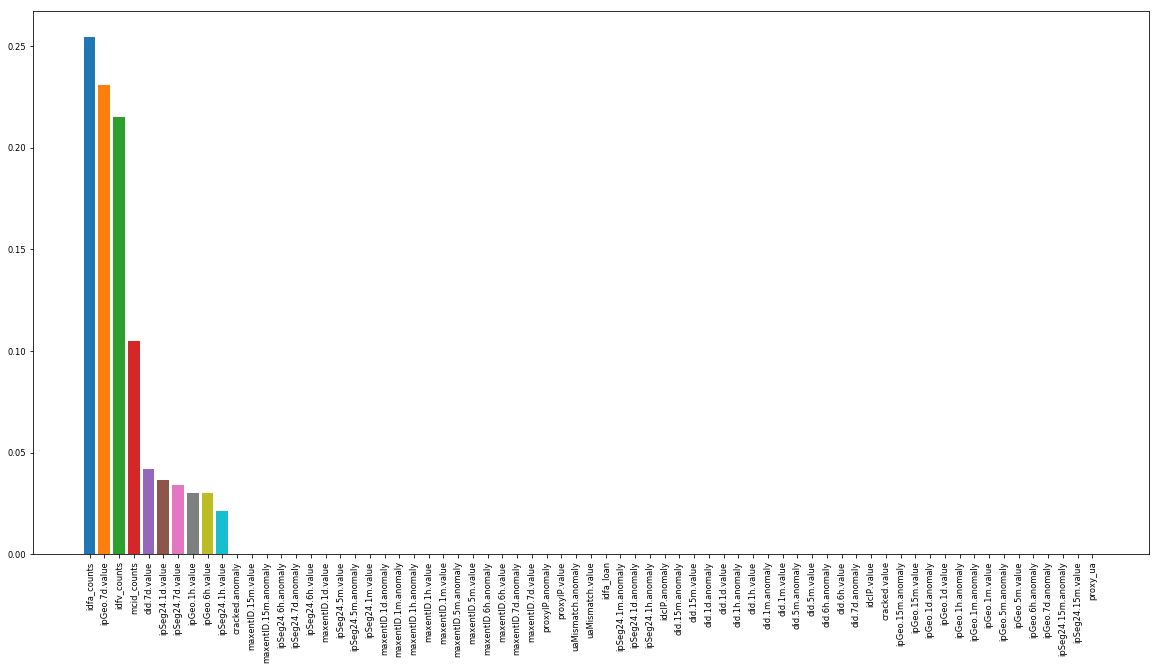

In [45]:
df_feature_ios = pd.DataFrame(X_ios_train.columns.values,columns=['column'])
df_importance = pd.DataFrame(clf_0.feature_importances_,columns=['feature importances'])
df_ios_fim = pd.concat([df_feature_ios,df_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_ios_fim=df_ios_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_ios_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_ios_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/ios_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [46]:
df_android = df.loc[df.os == 'android']
df_android = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_android)
df_android_test = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_android_test)

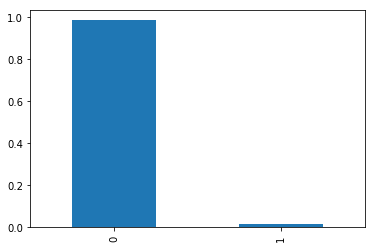

In [47]:
df_android.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/android_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [48]:
df_android[show_missing()].isnull().sum()

Series([], dtype: float64)

In [49]:
android_drop = ['os','idfa_loan','idfa_counts', u'idfv_counts','imei_loan']
df_android =df_android.drop(android_drop,axis=1)
df_android_test =df_android_test.drop(android_drop,axis=1)

In [50]:
df_android_train = df_android
X_android_train = df_android_train.ix[:, df_android_train.columns != 'label']
X_android_test  = df_android_test.ix[:,  df_android_test.columns != 'label']
y_android_train = df_android_train.ix[:, df_android_train.columns == 'label']
y_android_test  = df_android_test.ix[:,  df_android_test.columns == 'label']
print("Number transactions android train dataset: ", X_android_train.shape[0])
print("Number transactions android train dataset: ", y_android_train.shape[0])
print("Number transactions android test dataset: ", X_android_test.shape[0])
print("Total number of android transactions: ", X_android_train.size)

Number transactions android train dataset:  151329
Number transactions android train dataset:  151329
Number transactions android test dataset:  93908
Total number of android transactions:  10744359


In [51]:
 y_android_test.label.value_counts()

0    89950
1     3958
Name: label, dtype: int64

In [52]:
X_android_cols = X_android_train.columns
X_android_train_cv = X_android_train[X_android_cols]
y_android_train_cv = y_android_train['label']
android_params,_clf = gridCV(clf=tree.DecisionTreeClassifier,X=X_android_train_cv,y=y_android_train_cv,
                             base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)



find best params of {'min_samples_split': [30, 40, 50, 60, 70, 80, 90]}
find best params of {'max_leaf_nodes': [2, 4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_impurity_decrease': [0.0, 0.01, 0.02, 0.03, 0.04]}
find best params of {'max_depth': [4, 6, 8, 10, 12, 14, 16, 18]}
find best params of {'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90]}
get grid score is [mean: 0.57268, std: 0.05696, params: {'min_samples_leaf': 30}, mean: 0.57268, std: 0.05696, params: {'min_samples_leaf': 40}, mean: 0.57255, std: 0.05696, params: {'min_samples_leaf': 50}, mean: 0.57255, std: 0.05696, params: {'min_samples_leaf': 60}, mean: 0.57251, std: 0.05697, params: {'min_samples_leaf': 70}, mean: 0.57250, std: 0.05698, params: {'min_samples_leaf': 80}, mean: 0.57250, std: 0.05698, params: {'min_samples_leaf': 90}]
get best parameters is {'random_state': 27, 'criterion': 'gini', 'min_samples_split': 80, 'max_leaf_nodes': 18, 'min_samples_leaf': 30, 'max_depth': 8, 'min_impurity_decrease': 0.0, 

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


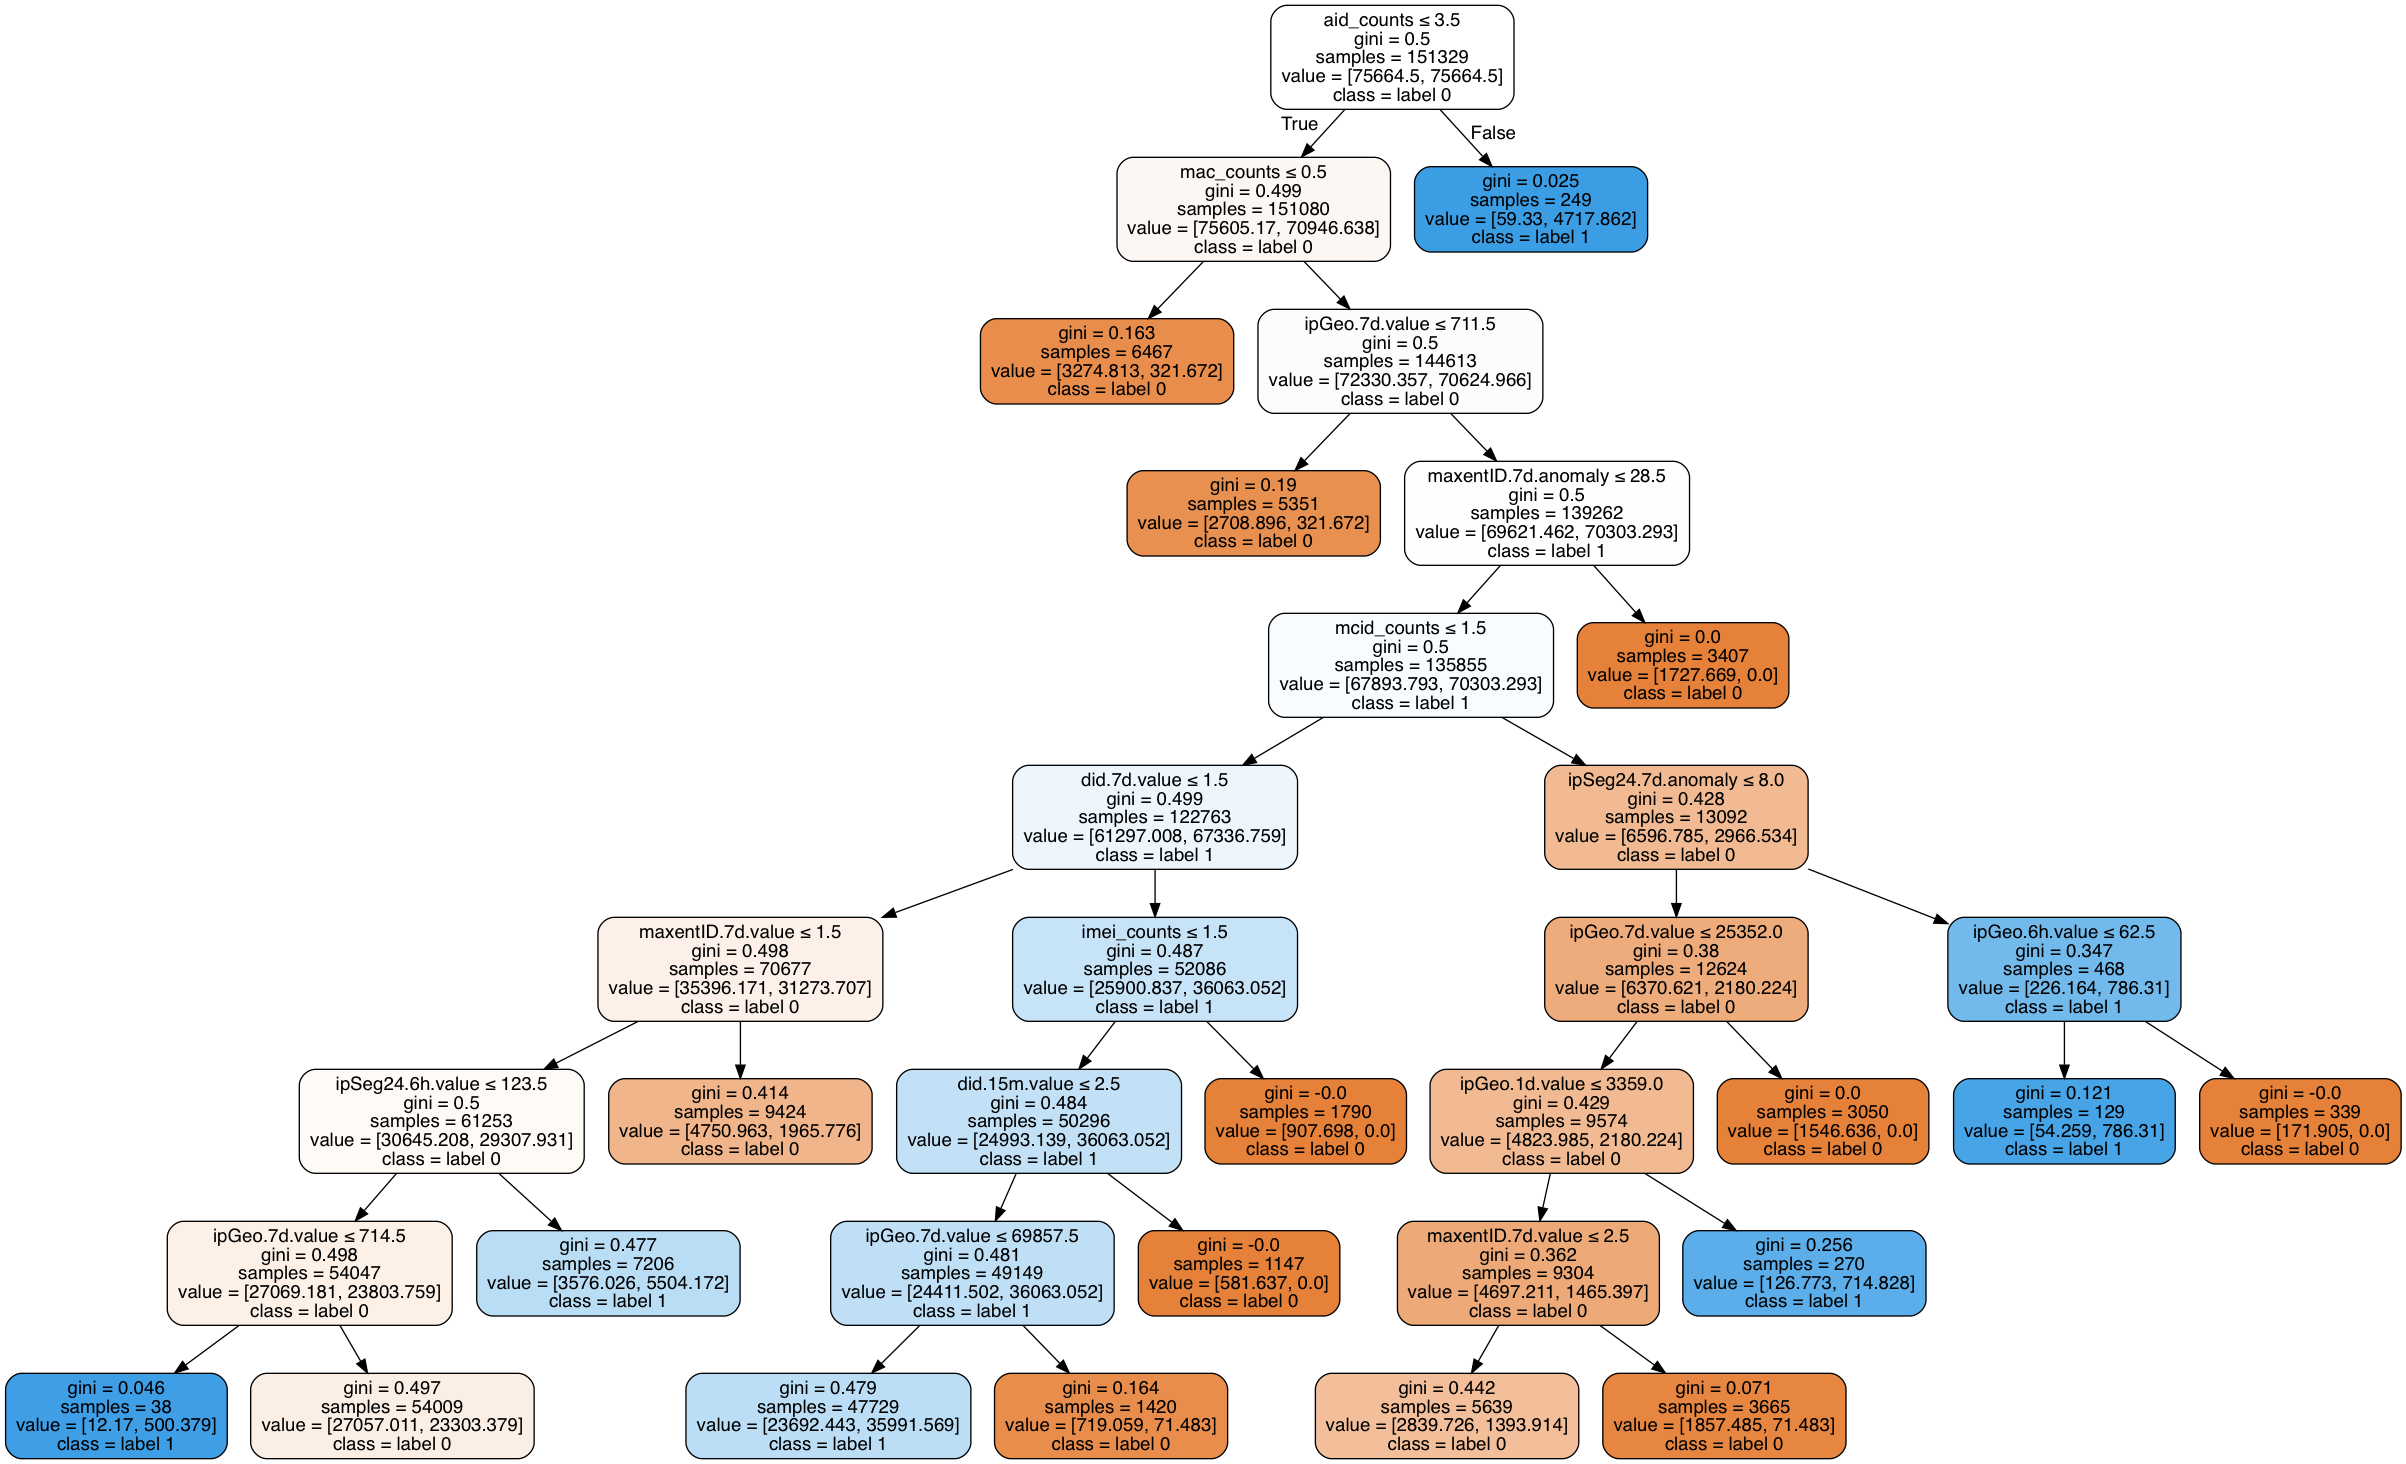

In [53]:
clf_android = tree.DecisionTreeClassifier(**android_params)
clf_1 = clf_android.fit(X_android_train, y_android_train)

dot_data_android = tree.export_graphviz(clf_1, out_file=None, feature_names=X_android_train.columns,class_names=['label 0','label 1'],\
                               filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graph_from_dot_data(dot_data_android)
# graph.write_pdf("dec_tree.pdf")
Image(graph.create_png())

In [54]:
save_path = image_path + "/android_tree-{0}-{1}-{2}.png".format(version,ratio,model)
print(save_path)
graph.write_png(save_path)

/Users/chaoxu/code/local-spark/Data/image_qiancheng/android_tree-6-0.01-tree.png


True

In [55]:
def get_android_group_label(row):
#     if row['y_android_test'].values[0] == 1:
    return row['y_android_pred'].max()
#     else:
#         return row['y_android_pred'].min()


(93908, 71)
(12665,)
Recall metric in the testing dataset:  0.398
Precision metric in the testting dataset: 0.0376466136966
f2 metric in the testting dataset: 7.32261306533
             precision    recall  f1-score   support

          0       0.96      0.58      0.72     12165
          1       0.04      0.40      0.07       500

avg / total       0.92      0.57      0.70     12665



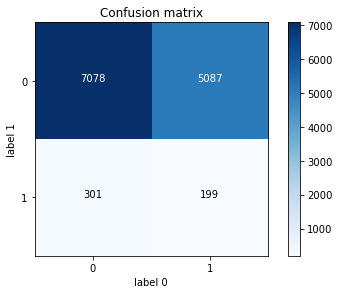

In [56]:
y_android_pred = clf_1.predict(X_android_test)

df_y_android_pred = pd.DataFrame(y_android_pred,columns=['y_android_pred'])
df_y_android_test = pd.DataFrame(y_android_test.values,columns=['y_android_test'])
df_android_pred = pd.concat([df_android_maxent_id,df_y_android_pred,df_y_android_test],axis=1)
df_android_pred_g = df_android_pred.groupby(['maxent_id','y_android_test'])
# df_android_pred_g['y_android_pred_max'] = df_android_pred_g.apply(lamda x:get_android_group_label(x))

df_android_pred_g_apply=df_android_pred_g.apply(lambda x:get_android_group_label(x)).reset_index(name='y_android_pred_max')

y_android_test_m = df_android_pred_g_apply['y_android_test']
y_android_pred_m = df_android_pred_g_apply['y_android_pred_max']
print(X_android_test.shape)
print(y_android_test_m.shape)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_android_test_m,y_android_pred_m)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_android_test_m, y_android_pred_m, target_names=['0','1']))
save_path = image_path + "/tree_android_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

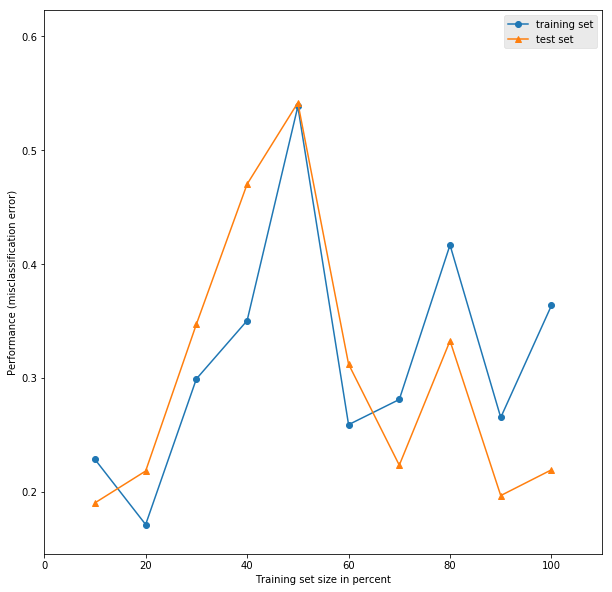

In [57]:
from mlxtend.plotting import plot_learning_curves
y_android_train_f = y_android_train.label.astype(float)
y_android_test_f = y_android_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_android_train, y_android_train_f, X_android_test, y_android_test_f, clf_1, print_model=False,style='ggplot')

save_path = image_path + "/android_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


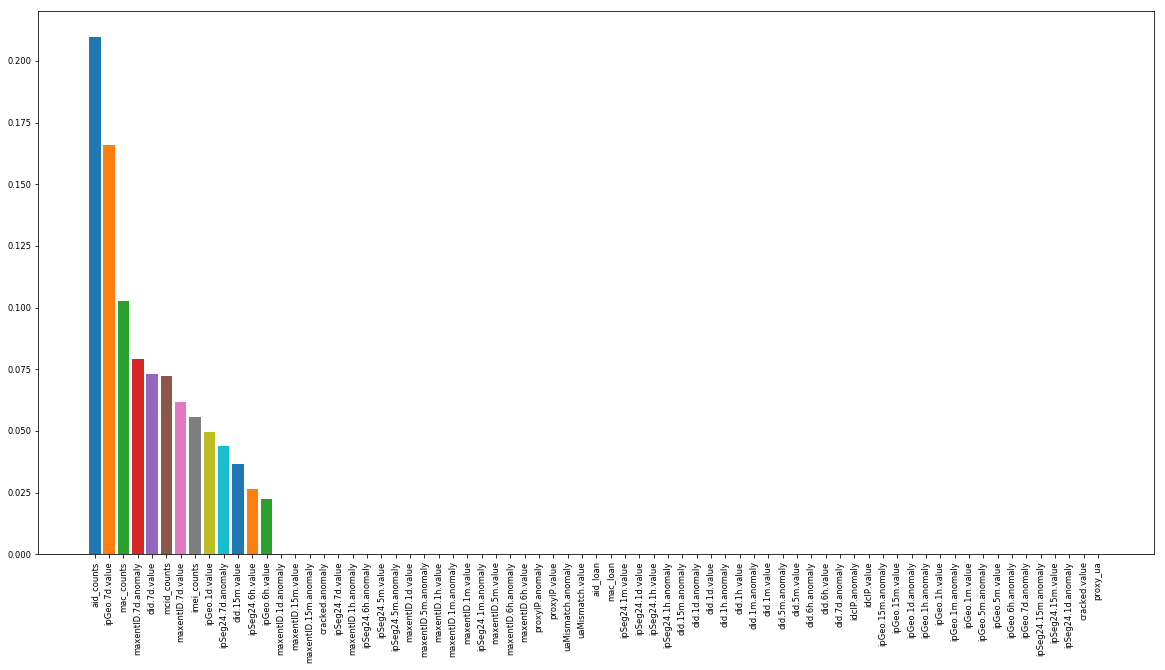

In [58]:
df_feature_android = pd.DataFrame(X_android_train.columns.values,columns=['column'])
df_android_importance = pd.DataFrame(clf_1.feature_importances_,columns=['feature importances'])
df_android_fim = pd.concat([df_feature_android,df_android_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_android_fim=df_android_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_android_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_android_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/android_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()